## FLOW_META_API Single Turbine
### A four steps calibration and uncertainty prediction framework
##### Step 1 - Sampling : Generate a mapping of a chosen error metric using a set of chosen model parameters. Return a netcdf of this mapping. 
##### Step 2 - Sensitivity : Learn the errors using PCE. Return a netcdf of Sobol indices : dependency on physical parameters, and aggregation.
##### Step 3 - Calibration : Read the outputs of Sampling and Sensitivity to decide what parameters to calibrate.

<font color='blue'>General libraries</font> 

In [1]:
%matplotlib inline
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import scipy.stats as stats
#
from windIO.utils.yml_utils import validate_yaml, load_yaml
from windIO.utils import plant_schemas_path

<font color='blue'> WIFA libraries</font> 

In [2]:
from wifa.pywake_api import run_pywake  # , run_wayve, run_code_saturne
from wifa.foxes_api import run_foxes
from generalize_database_creation import *
from perform_PCE_on_database import *

<font color='blue'>Toy problem data </font> 

In [3]:
calibration_windio_input_yaml = "1WT_simulations/windIO_1WT/wind_energy_system/system.yaml"
validate_yaml(calibration_windio_input_yaml, plant_schemas_path + "wind_energy_system.yaml")
calibration_windio_input_data = load_yaml(calibration_windio_input_yaml)
#
calibration_reference_flow_field = xr.load_dataset('1WT_simulations/result_code_saturne_1WT_FULL/flow_field_interpolated.nc')
calibration_reference_turbine_data = xr.load_dataset('1WT_simulations/result_code_saturne_1WT_FULL/turbine_data.nc')
calibration_reference_physical_inputs= xr.load_dataset('1WT_simulations/windIO_1WT/plant_energy_resource/1WT_calibration_data_IEA15MW.nc')

Validation succeeded


<font color='blue'> Step 1 : error mapping </font> 

##### Run the sampling and store into netcdf

In [4]:
if(False): #set true to generate the netcdf
    calibration_model_param_config = {
        "attributes.analysis.wind_deficit_model.wake_expansion_coefficient.k_b": (0.01, 0.3),
        "attributes.analysis.blockage_model.ss_alpha": (0.01, 0.3)
    }
    UQ_mapping_results = run_parameter_sweep(calibration_windio_input_data, calibration_model_param_config, \
                                  calibration_reference_physical_inputs, calibration_reference_flow_field, \
                                  n_samples=100, seed=3)
    UQ_mapping_results.to_netcdf('UQ_mapping_results.nc')

##### Read a precomputed sampling from netcdf

In [5]:
UQ_mapping_results = xr.load_dataset('UQ_mapping_results.nc')
UQ_mapping_results_keys = list(UQ_mapping_results.keys())
UQ_mapping_results_coords = list(UQ_mapping_results.coords)

##### Illustrate content

Physical fields and parameters : ['wind_diff', 'z0', 'ABL_height', 'wind_speed', 'wind_direction', 'LMO', 'lapse_rate', 'capping_inversion_strength', 'capping_inversion_thickness', 'turbulence_intensity']
Coordinates including the model parameters : ['z', 'time', 'sample', 'k_b', 'ss_alpha']


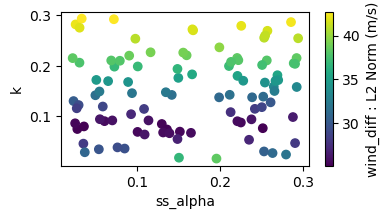

In [6]:
#
print("Physical fields and parameters :",UQ_mapping_results_keys)
print("Coordinates including the model parameters :",UQ_mapping_results_coords)
#
fig, ax = plt.subplots(1,1,figsize=(4,2))
plt.scatter(UQ_mapping_results.ss_alpha, UQ_mapping_results.k_b, c=UQ_mapping_results.wind_diff.min('time'))
cbar = plt.colorbar()
plt.xlabel('ss_alpha')
plt.ylabel('k')
cbar.set_label('wind_diff : L2 Norm (m/s)')
plt.show()

<font color='blue'> Step 2 : PCE learning - v1 : given time </font>

##### Physical and model parameters
<font color='red'>TODO : automatically decide what physical_inputs and error_metrics for the netcdf</font> 

In [7]:
physical_inputs_varnames = ['z0', 'ABL_height', 'wind_speed']
output_variable_name = "wind_diff"
model_param_varnames = [coord for coord in UQ_mapping_results_coords if (not(coord in ['time','z','sample']))]
print("Physical parameters : ", physical_inputs_varnames)
print("Model parameters : ", model_param_varnames)
print("Error metric name : ", output_variable_name)

Physical parameters :  ['z0', 'ABL_height', 'wind_speed']
Model parameters :  ['k_b', 'ss_alpha']
Error metric name :  wind_diff


##### Few prints to illustrate the content

In [8]:
#
sample_size=len(UQ_mapping_results.sample)
physical_size = len(UQ_mapping_results.time)
print("\nSample size is : ",sample_size, "(realizations of model params).", \
      " Number of physical times is : ", physical_size, "(realizations of physical params).", \
      "\nResulting shape of the error_metric table ('wind_diff') is :",np.array(UQ_mapping_results.isel().get(output_variable_name)).shape)
#
it=0 ; isp=0
print("\nVerification prints for time ",UQ_mapping_results.time.data[it], "and sample id ",isp, \
      ":\n  Physical params: ", physical_inputs_varnames, "=",[str(UQ_mapping_results.isel(time=it, sample=isp).get(physical_inputs_varnames[i]).data) \
                                                             for i in range(len(physical_inputs_varnames))], \
      "\n  Model params: ", model_param_varnames, "=",[str(UQ_mapping_results.isel(time=it, sample=isp).get(physical_inputs_varnames[i]).data) \
                                                             for i in range(len(physical_inputs_varnames))], \
      "\n  Error metric (relative to reference): ",output_variable_name," = ",  UQ_mapping_results.isel(time=it, sample=isp).wind_diff.data[0])
#
#print(np.array(UQ_mapping_results.isel(time=it).get('wind_diff')).shape)
#print(np.array(UQ_mapping_results.isel(time=it, sample=isp).get('wind_diff')).shape)


Sample size is :  100 (realizations of model params).  Number of physical times is :  108 (realizations of physical params). 
Resulting shape of the error_metric table ('wind_diff') is : (100, 108, 1)

Verification prints for time  0.0 and sample id  0 :
  Physical params:  ['z0', 'ABL_height', 'wind_speed'] = ['1e-05', '174.632', '8.0'] 
  Model params:  ['k_b', 'ss_alpha'] = ['1e-05', '174.632', '8.0'] 
  Error metric (relative to reference):  wind_diff  =  100.05570083672592


##### Learn PCE and get Sobol Indices

In [9]:
### PCE example for given time it
it=10 #selected evaluation time
PCE_deg=5
marginals = ["kernel", "kernel"] #agnostic=kernel. choices: uniform, gaussian
copula = "independent"  #dependency btw the random variables, choices: gaussian, independent
Sobol_indices_1stOrder, Sobol_indices_Total, PCE_metamodel  =  build_PCE_for_given_time(UQ_mapping_results, model_param_varnames, \
                                                                                        output_variable_name,it,PCE_deg, marginals, copula)

print("Sobol indices at time id, ",it,"and model params ", model_param_varnames," : ",Sobol_indices_1stOrder)
example_k=0.1 ; example_alpha_ss = 0.05
print("Example of metamodel evaluation :", PCE_metamodel(np.array([example_k,example_alpha_ss]))[0]) #error(k, alpha_ss) ~ PCE(k, alpha_ss)

Sobol indices at time id,  10 and model params  ['k_b', 'ss_alpha']  :  [0.9891347599037437, 0.0012648073194930338]
Example of metamodel evaluation : 53.118445125379125


In [10]:
### For all times
allTimes_Sobol_indices_1stOrder, allTimes_Sobol_indices_Total, \
    allTimes_PCE_metamodels  = build_PCE_for_all_times(UQ_mapping_results, model_param_varnames, \
                                                       output_variable_name,PCE_deg, marginals, copula)

In [11]:
#Print chosen time
it=20
print("Sobol indices at time id, ",it,"and model params ", model_param_varnames," : ",allTimes_Sobol_indices_1stOrder[it,:])
example_k=0.1 ; example_alpha_ss = 0.05
print("Example of metamodel evaluation :", allTimes_PCE_metamodels[it](np.array([example_k,example_alpha_ss]))[0]) #error(k, alpha_ss) ~ PCE(k, alpha_ss)

Sobol indices at time id,  20 and model params  ['k_b', 'ss_alpha']  :  [0.9966575 0.       ]
Example of metamodel evaluation : 66.11931134926678


##### Sobol indices plot

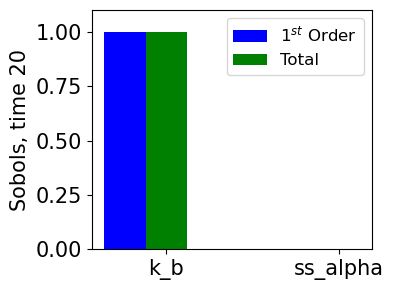

In [12]:
#########Plot Sobol indices############
it=20 #chosen time
fig,ax = plt.subplots(1,1,figsize=(4,3))
##### Bar positions
bar_width=0.24
bar_positions1 = np.arange(len(model_param_varnames)) + 0.5*bar_width
bar_positions2 = np.arange(len(model_param_varnames)) + 1.5*bar_width
values1 = []
values2 = []
for j in range(len(model_param_varnames)):
    values1.append(allTimes_Sobol_indices_1stOrder[it,j])
    values2.append(allTimes_Sobol_indices_Total[it,j])
#####
# Create bar plots
ax.bar(bar_positions1, values1, width=bar_width, label='$1^{st}$ Order', color="blue")
ax.bar(bar_positions2, values2, width=bar_width, label='Total', color="green")

# Set labels
ax.set_ylabel("Sobols, time "+str(it))
ax.set_xticks(bar_positions2) , ax.set_xticklabels(model_param_varnames)
ax.legend(loc="upper right", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15) , ax.yaxis.label.set_size(15)
ax.set_ylim(0.0,1.1)

# Show the plot
plt.tight_layout()
plt.show()

<font color='blue'> Step 2 : PCE learning - v2 : aggregated </font> 

In [13]:
### PCE for selected modes
PCE_deg=5
marginals = ["kernel", "kernel"] #agnostic=kernel. choices: uniform, gaussian
copula = "independent"  #dependency btw the random variables, choices: gaussian, independent

#########Set the data from previous###############
aggregated_Sobol_indices_1stOrder, aggregated_Sobol_indices_Total  =  build_POD_PCE(UQ_mapping_results, model_param_varnames, \
                                                                                        output_variable_name,PCE_deg, marginals,copula,target_POD_EVR=0.99)

print("Aggregated Sobol indices for model params ", model_param_varnames," : ",aggregated_Sobol_indices_1stOrder)

Aggregated Sobol indices for model params  ['k_b', 'ss_alpha']  :  [9.88333121e-01 7.28249553e-04]


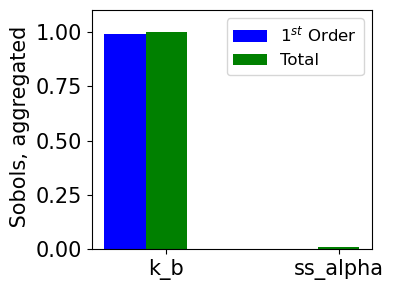

In [14]:
#########Plot Sobol indices############
fig,ax = plt.subplots(1,1,figsize=(4,3))
##### Bar positions
bar_width=0.24
bar_positions1 = np.arange(len(model_param_varnames)) + 0.5*bar_width
bar_positions2 = np.arange(len(model_param_varnames)) + 1.5*bar_width
values1 = []
values2 = []
for j in range(len(model_param_varnames)):
    values1.append(aggregated_Sobol_indices_1stOrder[j])
    values2.append(aggregated_Sobol_indices_Total[j])
#####
# Create bar plots
ax.bar(bar_positions1, values1, width=bar_width, label='$1^{st}$ Order', color="blue")
ax.bar(bar_positions2, values2, width=bar_width, label='Total', color="green")

# Set labels
ax.set_ylabel(" Sobols, aggregated")
ax.set_xticks(bar_positions2) , ax.set_xticklabels(model_param_varnames)
ax.legend(loc="upper right", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15) , ax.yaxis.label.set_size(15)
ax.set_ylim(0.0,1.1)

# Show the plot
plt.tight_layout()
plt.show()

#### Storing Sensitivity Analysis into netcdf file

In [38]:
# Add parameter values to dataset
import xarray as xr
SA_data = xr.Dataset(
    data_vars=dict(Sobols_1stOrder=(["time","model_params"], allTimes_Sobol_indices_1stOrder), 
                   Sobols_Total=(["time","model_params"], allTimes_Sobol_indices_Total), 
                   Aggregated_Sobols_1stOrder=(["model_params"], aggregated_Sobol_indices_1stOrder),
                   Aggregated_Sobols_Total=(["model_params"], aggregated_Sobol_indices_Total)
                  ),
    coords={
                'time': xr.DataArray(UQ_mapping_results.time,dims=['time'],coords={'time': UQ_mapping_results.time}),                 
                'model_params': xr.DataArray(model_param_varnames, dims=['model_params'], coords={'model_params': model_param_varnames})            
        }
    )

# Add reference data
refdat = UQ_mapping_results
for var in refdat.data_vars:
    SA_data[var] = refdat[var]    

print(SA_data)
SA_data.to_netcdf('SA_results.nc')

<xarray.Dataset> Size: 97kB
Dimensions:                      (time: 108, model_params: 2, sample: 100,
                                  altitudes: 1)
Coordinates:
  * time                         (time) float32 432B 0.0 1.0 2.0 ... 106.0 107.0
  * model_params                 (model_params) <U8 64B 'k_b' 'ss_alpha'
    z                            int64 8B 150
  * sample                       (sample) int64 800B 0 1 2 3 4 ... 96 97 98 99
    k_b                          (sample) float64 800B 0.1697 0.2154 ... 0.06695
    ss_alpha                     (sample) float64 800B 0.0657 0.2204 ... 0.1393
Dimensions without coordinates: altitudes
Data variables: (12/14)
    Sobols_1stOrder              (time, model_params) float64 2kB 0.9957 ... 0.0
    Sobols_Total                 (time, model_params) float64 2kB 0.9997 ... ...
    Aggregated_Sobols_1stOrder   (model_params) float64 16B 0.9883 0.0007282
    Aggregated_Sobols_Total      (model_params) float64 16B 0.9991 0.01149
    wind_diff   